# Table of Contents
 <p><div class="lev1"><a href="#Task-1.-Compiling-Ebola-Data"><span class="toc-item-num">Task 1.&nbsp;&nbsp;</span>Compiling Ebola Data</a></div>
 <div class="lev1"><a href="#Task-2.-RNA-Sequences"><span class="toc-item-num">Task 2.&nbsp;&nbsp;</span>RNA Sequences</a></div>
 <div class="lev1"><a href="#Task-3.-Class-War-in-Titanic"><span class="toc-item-num">Task 3.&nbsp;&nbsp;</span>Class War in Titanic</a></div></p>

In [1]:
DATA_FOLDER = '../../Data' # Use the data folder provided in Tutorial 02 - Intro to Pandas.

## Task 1. Compiling Ebola Data

The `DATA_FOLDER/ebola` folder contains summarized reports of Ebola cases from three countries (Guinea, Liberia and Sierra Leone) during the recent outbreak of the disease in West Africa. For each country, there are daily reports that contain various information about the outbreak in several cities in each country.

Use pandas to import these data files into a single `Dataframe`.
Using this `DataFrame`, calculate for *each country*, the *daily average* per year of *new cases* and *deaths*.
Make sure you handle all the different expressions for *new cases* and *deaths* that are used in the reports.

In [2]:
# Write your answer here
#first We need to import the data as a dataframe of course it means importing pandas
#create a unique dataframe with country:date::

In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
from IPython.display import display
import glob
import math 
import matplotlib.pyplot as plt
import datetime
from dateutil.parser import parse

In [4]:
##Create a column with name of the country in the beginning of the frame
def add_pays(data_frame, pays):
    data_frame.loc[:,'Pays'] = pd.Series(pays, index=data_frame.index)
    cols = list(data_frame)
    cols.insert(0, cols.pop(cols.index('Pays')))
    data_frame = data_frame.loc[:, cols]
    return data_frame

#import the csv files of one country and put them in one frame
def create_oneframe(pays):
    allFiles = glob.glob(DATA_FOLDER + "/ebola/%s_data/*.csv"%pays)
    list_ = []
    frame=pd.DataFrame()
    for file_ in allFiles:
        df = pd.read_csv(file_,)
        if not frame.empty:
            frame = pd.merge(frame, df, how='outer')
        else :
            frame = df
    return frame

In [5]:
pays1='guinea'
pays2='liberia'
pays3='sl'   #Sierra Leone

guinea=add_pays(create_oneframe(pays1),(pays1))
liberia=add_pays(create_oneframe(pays2),(pays2))
sl=add_pays(create_oneframe(pays3),(pays3))

In [6]:
all_country=pd.DataFrame()
all_country=pd.merge(sl,guinea,how='outer')
all_country=pd.merge(all_country,liberia,how='outer')

##create a new column for country that dont have one. guinea:Totals, liberia:National
## and a new date and new description
#all_country=all_country.fillna('')
all_country["Description"] = all_country["Description"].fillna('').map(str) + all_country["Variable"].fillna('').map(str)+all_country["variable"].fillna('').map(str)
all_country["Date"] = all_country["Date"].fillna('').map(str) + all_country["date"].fillna('').map(str)
all_country['National']=all_country['National'].fillna('').map(str)+all_country['Totals'].fillna('').map(str)

##Delete the old ones
cols = list(all_country)
cols.pop(cols.index('Variable'))
cols.pop(cols.index('variable'))
cols.pop(cols.index('date'))
cols.pop(cols.index('Totals'))
cols.insert(1, cols.pop(cols.index('Date')))
cols.insert(2, cols.pop(cols.index('Description')))
cols.insert(3, cols.pop(cols.index('National')))
all_country = all_country.loc[:, cols]


In [7]:
#TODO: search for missing values in National: if empty sum following columns
###Pour remplir les totaux vides
Natio_empty=np.where((all_country.National==''))[0]


all_country.replace({'-':0},inplace=True)
for i in all_country.index[Natio_empty]:
    #Due to the impossibility to delete % We chose to avoid those lines
    if  i!=818 and i!=1150:
        all_country.iloc[i,3]=pd.Series.sum(all_country.iloc[i,4:].astype(float))

display(all_country.iloc[(all_country.index[Natio_empty])].head())

###or delete those rows 

#print(len(Natio_empty))
#print(len(all_country))
#all_country.drop(all_country.index[Natio_empty],inplace=True)

### The rows deleted are not important for the main Description

#display(all_country.index[Natio_empty])






,Pays,Date,Description,National,Kailahun,Kenema,Kono,Kambia,Koinadugu,Bombali,...,Maryland County,Montserrado County,Nimba County,River Gee County,RiverCess County,Sinoe County,Gbarpolu County,Grand Bassa,Grand Cape Mount,Grand Gedeh
297,sl,2014-08-12,etc_new_admission,23,16,7,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
298,sl,2014-08-12,etc_currently_admitted,94,53,41,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
299,sl,2014-08-12,etc_cum_admission,644,341,303,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
300,sl,2014-08-12,etc_new_deaths,8,5,3,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
301,sl,2014-08-12,etc_cum_deaths,258,104,154,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
#Now we have a dataframe with which we can work. 
#The goal here is to calculate the daily average of each description since it is not clear which one is necessary


countries=['guinea','liberia','sl']

#create new column with our daily average
all_country['Daily Average']=np.nan
cols = list(all_country)
cols.insert(3, cols.pop(cols.index('Daily Average')))
all_country = all_country.loc[:, cols]

for country in countries:
    #work with dataframe of the country
    one_country=all_country[all_country.Pays.str.startswith(country)]
    descriptions=one_country.Description.unique()
    for desc in (descriptions):
        one_description=one_country.loc[one_country.Description==desc,:]
        #does not work very weird:
        #one_description=one_country.loc[one_country.Description.str.contains('New case/s con')]
        if (True in one_description['National'].str.contains(',').values+\
            one_description['National'].str.contains('%').values):
            print('description rejected:%s'%(desc))
        else: 
            descr_mean=(one_description['National']).astype(float).mean()
            if (("new" not in desc) and ('New' not in desc)) and len(one_description['National'])!=0:
                descr_mean=max(one_description['National'].astype(float))/len(one_description['National'])
            #print(descr_mean)
            all_country.loc[(all_country.Pays==country) \
                            & (all_country.Description==desc),'Daily Average']=descr_mean
        
        #all_country[(all_country.Pays.any()==country) and (all_country.Description==desc)]

description rejected:Fatality rate for confirmed and probables
description rejected:population
description rejected:cum_noncase
description rejected:cum_confirmed
description rejected:percent_seen
description rejected:pending


In [9]:
#Now for anytype of Description it is possible to have the daily average easily:

descr_dict={}
description='new_contacts'
for country in countries:
    average=all_country.loc[(all_country.Pays==country)& (all_country.Description.str.contains(description)),:]['Daily Average'].unique()
    descr_dict[country]=average
print('For the description:"%s" \n %s'%(description,descr_dict))

#or just plot the full data frame for a specific country and description
display(all_country.loc[(all_country.Pays=='liberia') & (all_country.Description.str.contains('New')),:])

For the description:"new_contacts" 
 {'guinea': array([], dtype=float64), 'liberia': array([], dtype=float64), 'sl': array([ 299.38834951])}


,Pays,Date,Description,Daily Average,National,Kailahun,Kenema,Kono,Kambia,Koinadugu,...,Maryland County,Montserrado County,Nimba County,River Gee County,RiverCess County,Sinoe County,Gbarpolu County,Grand Bassa,Grand Cape Mount,Grand Gedeh
3977,liberia,6/16/2014,New admissions,20.99,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3980,liberia,6/16/2014,New Case/s (Probable),123.76,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3981,liberia,6/16/2014,New case/s (confirmed),176.60,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3984,liberia,6/16/2014,Newly Reported Cases in HCW,0.81,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3985,liberia,6/16/2014,Newly Reported deaths in HCW,0.33,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3988,liberia,6/16/2014,Newly reported deaths,20.38,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3990,liberia,6/16/2014,New Case/s (Suspected),201.65,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3997,liberia,6/16/2014,Newly reported contacts,151.61,41.0,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4009,liberia,6/17/2014,New admissions,20.99,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4010,liberia,6/17/2014,New Case/s (Suspected),201.65,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
#Here the new death confirmed and new cases confirmed  are calculated for each country in a slightly different way
death_dict={}
newcase_dict={}
#Boolean to print the evolution of the new death confirmed and new cases confirmed 
print_evolution=False
for country in countries:

    one_country=all_country[all_country.Pays.str.startswith(country)]

    #frame with only rows of new cases confirmed:
    country_new=one_country[one_country.Description.str.contains('New',case=False)& (one_country.Description.str.contains('confirmed'))\
                             &(~one_country.Description.str.contains('Death',case=False))&(~one_country.Description.str.contains('workers',case=False))]
    #average over the columns
    #news cases confirmed daily average over the year
    newcase_dict[country]=(country_new.National.astype(float).mean())
    #frame with only rows of death cases confirmed:
    country_death=one_country[one_country.Description.str.contains('deaths',case=False) & ~(one_country.Description.str.contains('HCW'))\
                             &(one_country.Description.str.contains('new',case=False)) &~(one_country.Description.str.contains('proba'))\
                             &~(one_country.Description.str.contains('workers'))&~(one_country.Description.str.contains('confirmed'))]
    #daily death average over year :
    death_dict[country]=(country_death.National.astype(float).mean())
    
    ###plot of the new cases:
    date=country_death.Date.tolist()
    date=[parse(x) for x in date]
    newcase=country_new.National.astype(float).tolist()
    date, newcase = zip(*sorted(zip(date, newcase)))
    
    
    ###plot of the death everyday (in increasing date)
    date=country_death.Date.tolist()
    date=[parse(x) for x in date]
    death=country_death.National.astype(float).tolist()
    date, death = zip(*sorted(zip(date, death)))
    if print_evolution:

        plt.plot(newcase)
        plt.title(country)
        plt.xlabel('Days')
        plt.ylabel('New cases')
        plt.show()

        plt.plot(death)
        plt.title(country)
        plt.xlabel('Days')
        plt.ylabel('New Deaths')
        plt.show()

print('New cases average:%s'%newcase_dict)
print('death average:%s'%death_dict)
print('Libera was the most affected country')

New cases average:{'guinea': 12.545454545454545, 'liberia': 176.6, 'sl': 43.23300970873787}
death average:{'guinea': 3.869565217391304, 'liberia': 20.38, 'sl': 3.5533980582524274}
Libera was the most affected country


## Task 2. RNA Sequences

In the `DATA_FOLDER/microbiome` subdirectory, there are 9 spreadsheets of microbiome data that was acquired from high-throughput RNA sequencing procedures, along with a 10<sup>th</sup> file that describes the content of each. 

Use pandas to import the first 9 spreadsheets into a single `DataFrame`.
Then, add the metadata information from the 10<sup>th</sup> spreadsheet as columns in the combined `DataFrame`.
Make sure that the final `DataFrame` has a unique index and all the `NaN` values have been replaced by the tag `unknown`.

In [11]:
#Import necessary modules
import pandas as pd
import numpy as np
from IPython.display import display
import glob
import matplotlib.pyplot as plt
import datetime
from dateutil.parser import parse

In [12]:
#Loading the data for each MID file
microbiomePath = '../../Data/microbiome/MID'

for x in range(1, 10):
    path = "../../Data/microbiome/MID#.xls"
    path = path.replace('#',str(x))
    globals()['mb%s' % x] = pd.read_excel( path, header=None, index_col=0)
   # print(globals()['mb%s' % x].head())
#Loading Metadata as DataFrame 

metaData = pd.read_excel('../../Data/microbiome/metadata.xls')
metaData.loc[0,'SAMPLE'] = 'unknown'



In [13]:
#We create a list of DataFrames to facilitate the manipulation of the DataFrames
mbArray = [mb1,mb2,mb3,mb4,mb5,mb6,mb7,mb8,mb9]
count = 0;
# Adding Group and Sample for each microbiome DataFrame with the expected values from the metaData 
for x in mbArray :
    Group = np.repeat(metaData.loc[count,'GROUP'],len(x.index))
    Sample = np.repeat(metaData.loc[count,'SAMPLE'],len(x.index))
    x.columns = ['Values']
    x['Group'] = pd.Series(Group, index=x.index)
    x['Sample'] = pd.Series(Sample, index=x.index)
    x.index.name = 'Taxon'
    count += 1

In [14]:
#Creating an array with all the dataFrames
originalTables = []
for x in range (1,10):
    key = 'MID#'
    key = key.replace('#',str(x))
    originalTables.append(key)
    
finalMicrobiome = pd.concat(mbArray, keys=originalTables)

In [15]:

finalMicrobiome.index.is_unique

True

In [16]:
finalMicrobiome[::30]

Values  \
     Taxon                                                        
MID1 Archaea "Crenarchaeota" Thermoprotei Desulfuroc...       7   
     Bacteria "Actinobacteria" Actinobacteria Actino...       2   
     Bacteria "Bacteroidetes" "Sphingobacteria" "Sph...       3   
     Bacteria "Chloroflexi" Thermomicrobia Thermomic...       5   
     Bacteria "Firmicutes" "Clostridia" Clostridiale...       1   
     Bacteria "Proteobacteria" Alphaproteobacteria R...       1   
     Bacteria "Proteobacteria" Betaproteobacteria Bu...       2   
     Bacteria "Proteobacteria" Deltaproteobacteria B...       1   
     Bacteria "Proteobacteria" Gammaproteobacteria O...       1   
     Bacteria Cyanobacteria Cyanobacteria  Chloropla...      85   
MID2 Bacteria "Actinobacteria" Actinobacteria Actino...       1   
     Bacteria "Bacteroidetes" "Bacteroidia" "Bactero...       1   
     Bacteria "Chlamydiae" Chlamydiae Chlamydiales W...       1   
     Bacteria "Firmicutes" "Bacilli" Bacillales "Spo...       1   
     Bacteria "Firmicutes" "Clostridia" "Thermoanaer...       8   
     Bacteria "Firmicutes" "Clostridia" Clostridiale...       2   
     Bacteria "Proteobacteria" Alphaproteobacteria R...       4   
     Bacteria "Proteobacteria" Deltaproteobacteria D...       1   
     Bacteria "Proteobacteria" Gammaproteobacteria O...       3   
MID3 Archaea "Crenarchaeota" Thermoprotei Thermoprot...       3   
     Bacteria "Actinobacteria" Actinobacteria Actino...       1   
     Bacteria "Actinobacteria" Actinobacteria Actino...     105   
     Bacteria "Bacteroidetes" "Bacteroidia" "Bactero...       9   
     Bacteria "Bacteroidetes" Flavobacteria "Flavoba...       1   
     Bacteria "Firmicutes" "Bacilli" Bacillales "Pae...       7   
     Bacteria "Firmicutes" "Clostridia" "Thermoanaer...       2   
     Bacteria "Fusobacteria" "Fusobacteria" "Fusobac...       1   
     Bacteria "Proteobacteria" Alphaproteobacteria R...      12   
     Bacteria "Proteobacteria" Betaproteobacteria Bu...       6   
     Bacteria "Proteobacteria" Deltaproteobacteria M...       3   
...                                                         ...   
MID6 Bacteria "Deinococcus-Thermus" Deinococci Therm...       1   
     Bacteria "Firmicutes" "Bacilli" Bacillales Baci...      65   
     Bacteria "Firmicutes" "Clostridia" Clostridiale...      19   
     Bacteria "Proteobacteria" Deltaproteobacteria B...       1   
     Bacteria "Verrucomicrobia" Verrucomicrobiae Ver...       1   
MID7 Bacteria "Actinobacteria" Actinobacteria Actino...       3   
     Bacteria "Actinobacteria" Actinobacteria Actino...       7   
     Bacteria "Bacteroidetes" "Bacteroidia" "Bactero...       1   
     Bacteria "Bacteroidetes" Flavobacteria "Flavoba...      14   
     Bacteria "Firmicutes" "Bacilli" Bacillales "Pae...       2   
     Bacteria "Firmicutes" "Clostridia" Clostridiale...     231   
     Bacteria "Proteobacteria" Alphaproteobacteria K...       1   
     Bacteria "Proteobacteria" Alphaproteobacteria R...       3   
     Bacteria "Proteobacteria" Betaproteobacteria Bu...      10   
     Bacteria "Proteobacteria" Betaproteobacteria Rh...       6   
     Bacteria "Proteobacteria" Gammaproteobacteria "...       1   
     Bacteria "Proteobacteria" Gammaproteobacteria P...     410   
     Bacteria "Verrucomicrobia" Opitutae Puniceicocc...       2   
MID8 Bacteria "Bacteroidetes" "Sphingobacteria" "Sph...       3   
     Bacteria "Firmicutes" "Clostridia" "Thermoanaer...       2   
     Bacteria "Proteobacteria" Deltaproteobacteria D...       1   
MID9 Archaea "Euryarchaeota" Archaeoglobi Archaeoglo...       3   
     Bacteria "Bacteroidetes" "Sphingobacteria" "Sph...       1   
     Bacteria "Chloroflexi" Thermomicrobia Sphaeroba...       1   
     Bacteria "Firmicutes" "Bacilli" Bacillales Baci...     622   
     Bacteria "Firmicutes" "Clostridia" Clostridiale...      21   
     Bacteria "Firmicutes" "Erysipelotrichi" "Erysip...       8   
     Bacteria "Proteobacteria" Betapr

## Task 3. Class War in Titanic

Use pandas to import the data file `Data/titanic.xls`. It contains data on all the passengers that travelled on the Titanic.

In [17]:
from IPython.core.display import HTML
HTML(filename= DATA_FOLDER +'/titanic.html')

Name,Labels,Units,Levels,Storage,NAs
pclass,,,3,integer,0
survived,Survived,,,double,0
name,Name,,,character,0
sex,,,2,integer,0
age,Age,Year,,double,263
sibsp,Number of Siblings/Spouses Aboard,,,double,0
parch,Number of Parents/Children Aboard,,,double,0
ticket,Ticket Number,,,character,0
fare,Passenger Fare,British Pound (\243),,double,1
cabin,,,187,integer,0


For each of the following questions state clearly your assumptions and discuss your findings:
1. Describe the *type* and the *value range* of each attribute. Indicate and transform the attributes that can be `Categorical`. 
2. Plot histograms for the *travel class*, *embarkation port*, *sex* and *age* attributes. For the latter one, use *discrete decade intervals*. 
3. Calculate the proportion of passengers by *cabin floor*. Present your results in a *pie chart*.
4. For each *travel class*, calculate the proportion of the passengers that survived. Present your results in *pie charts*.
5. Calculate the proportion of the passengers that survived by *travel class* and *sex*. Present your results in *a single histogram*.
6. Create 2 equally populated *age categories* and calculate survival proportions by *age category*, *travel class* and *sex*. Present your results in a `DataFrame` with unique index.

In [18]:
## Import Excel file titanic.xls
titanic_data = pd.read_excel(DATA_FOLDER + '/titanic.xls') # size 1309 x 14
titanic_data

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
5,1,1,"Anderson, Mr. Harry",male,48.0000,0,0,19952,26.5500,E12,S,3,NaN,"New York, NY"
6,1,1,"Andrews, Miss. Kornelia Theodosia",female,63.0000,1,0,13502,77.9583,D7,S,10,NaN,"Hudson, NY"
7,1,0,"Andrews, Mr. Thomas Jr",male,39.0000,0,0,112050,0.0000,A36,S,NaN,NaN,"Belfast, NI"
8,1,1,"Appleton, Mrs. Edward Dale (Charlotte Lamson)",female,53.0000,2,0,11769,51.4792,C101,S,D,NaN,"Bayside, Queens, NY"
9,1,0,"Artagaveytia, Mr. Ramon",male,71.0000,0,0,PC 17609,49.5042,NaN,C,NaN,22.0,"Montevideo, Uruguay"


In [19]:
## Cleaning data ##
# Before starting, one needs to clean the data and do some data transformations

# First check NaN values in the data
titanic_data.isnull().any(); 
# This line told us what attributes get NaN values. As one can see only attribute for age, fare, cabin,embarked,boat,body and home.dest have Nan Values
# Now that we know which attributes have Nan Values, it is good to check the number of Nan Values for each attribute.
titanic_data.isnull().sum()
# One can see that cabin, boat and body have significant amounts of NaN value, therefore we cannot drop the entire row when there are NaN values for these attributes
# The number of NaN values specially for boat and cabin attributes are not the same as in the HTML file

pclass          0
survived        0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home.dest     564
dtype: int64

In [20]:
## -- 1 -- ## 
print('The type of each attribute is shown in the table below : ', end='\n')
print(titanic_data.dtypes) # Showing the type of each attribute
print('The value range of each attribute is shown in the table below : ', end='\n\n')
print(titanic_data.describe())

titanic_data['boat'] = titanic_data.boat.replace({'C D' : np.nan, '5 7': np.nan, '13 15': np.nan , '15 16' : np.nan, '5 9': np.nan, '13 15 B':np.nan, '8 10': np.nan }) # Change the value when there are multiple life boat number and put a Nan Value because when cannot know in which boat the passenger was in.
categorical_map = np.array(['pclass','survived','sex','embarked','boat','sibsp','parch']) # List of attributes that can be categorical (see discussion below for more informations)
     
for x in categorical_map : # This loop transforms the attributes that can be categorical.
    titanic_data[x] = titanic_data[x].astype('category')
    print(titanic_data[x].head())

The type of each attribute is shown in the table below : 
pclass         int64
survived       int64
name          object
sex           object
age          float64
sibsp          int64
parch          int64
ticket        object
fare         float64
cabin         object
embarked      object
boat          object
body         float64
home.dest     object
dtype: object
The value range of each attribute is shown in the table below : 

            pclass     survived          age        sibsp        parch  \
count  1309.000000  1309.000000  1046.000000  1309.000000  1309.000000   
mean      2.294882     0.381971    29.881135     0.498854     0.385027   
std       0.837836     0.486055    14.413500     1.041658     0.865560   
min       1.000000     0.000000     0.166700     0.000000     0.000000   
25%       2.000000     0.000000    21.000000     0.000000     0.000000   
50%       3.000000     0.000000    28.000000     0.000000     0.000000   
75%       3.000000     1.000000    39.000000     1

Discussion 1 :
- Regarding the type table, one can notice that the age's type is float64 but it could make more sense. However if it was in int64 but if the age was determine by the birth date then it makes sense
- Besides, one can notice that the types of the ticket number, life boat number and the cabin number are object because there are some letters in the values

- In the table, the value range is determine by [min,max]. One cant notice that there were babies and old person on the boat and the number of body identification is equal to 328 which is approximatively the number of body found. Also, some passengers didn't pay their ticket (free ticket)

- Categoricals are pandas datatype : a variable, which can take on only a limited and usually fixed, number of possible values
- Assumptions : boat = life boat according to us, we can put Nan Value for the passengers that have more than one value because unlike the cabine where a passenger could reserve more than 1 cabin a passenger couldn't have been in 2 different boat.

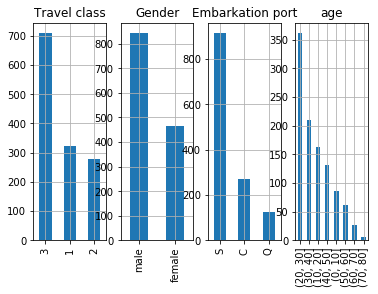

In [21]:
## -- 2 -- ##
# Plot 4 histograms using plot with kind = 'bar' and value_counts
plt.subplot(141)
titanic_data['pclass'].value_counts().plot(title = 'Travel class', kind='bar', grid = True) 
plt.subplot(142)
titanic_data['sex'].value_counts().plot(title = 'Gender', kind='bar', grid = True)
plt.subplot(143)
titanic_data['embarked'].value_counts().plot(title = 'Embarkation port', kind='bar', grid = True)
plt.subplot(144)
age_noNA = titanic_data['age'].dropna() # Drop NaN values to make sure they didn't bias the result
pd.cut(age_noNA,[0,10,20,30,40,50,60,70,80]).value_counts().plot(title = 'age', kind='bar', grid = True) #We don't need more than 80 years old since the maximun age is 80

Discussion 2 :
- Regarding the histograms, one can notice that there were more passenger travelling in Third class
- There were more male than female, almost twice
- Majority of the passengers embarked on port S
- One can notice that there were a lot of young passenger between 0 and 50 years old. 20 - 30 years old passengers were the greatest number.

The percentage of passenger on Cabin Floor A is equal to 7.482993 percent
The percentage of passenger on Cabin Floor B is equal to 22.108844 percent
The percentage of passenger on Cabin Floor C is equal to 31.972789 percent
The percentage of passenger on Cabin Floor D is equal to 15.646259 percent
The percentage of passenger on Cabin Floor E is equal to 13.945578 percent
The percentage of passenger on Cabin Floor F is equal to 7.142857 percent
The percentage of passenger on Cabin Floor G is equal to 1.700680 percent


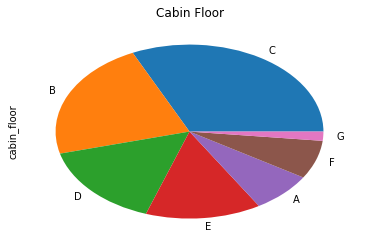

In [22]:
## -- 3 -- ##

titanic_data['cabin'] = titanic_data.cabin.replace({'T': np.nan }) # Drop the T value (see discussion below for more informations)
titanic_data['cabin_floor'] = titanic_data.cabin.copy().str[0] # Taking only the first letter which corresponds to the Floor
titanic_data['cabin_floor'] = titanic_data.cabin_floor.astype('category') # Create category for each floor
floor = np.zeros(len(titanic_data.cabin_floor.cat.categories))
for i,x in enumerate(titanic_data.cabin_floor.cat.categories) : # Loop to calculate the proportion for each Cabin floor
    floor[i] = titanic_data['cabin_floor'].value_counts()[i]*100/titanic_data['cabin_floor'].value_counts().sum() # Number of passenger of each floor divided by the number of passenger for which we know on what floor they were. 
    print('The percentage of passenger on Cabin Floor ' + x + ' is equal to %f percent' % floor[i]) 
    i = i+1
    
titanic_data['cabin_floor'].value_counts().plot(title = 'Cabin Floor', kind='pie') # Plot the proportion in a pie chart


Discussion 3 :
-  Assumptions : regarding the data and the HTML, passengers which have more than one cabine are on the same cabin floor
- Besides, regarding the map of all the deck of the titanic, one can notice that one floor F there are different section such as G or E, so for instance the cabin F EXX is on the F floor.
- The cabin T could be a typo or this cabin exist but since we don't know on which floor the cabin is, we just replace the value by NaN value.
- Assumptions : To calculate the proportion we are taking the number of passenger on each floor divided by the total number of passenger that we know on which floor they were, and not the number total of passengers
- One can notice that the floor B,C and D were the most occupied which makes sense since this floor corresponds to third and second class which were the greatest number.

The proportion of the passengers that survived for class 1 is : 61.919505 percent
The proportion of the passengers that survived for class 2 is : 42.960289 percent
The proportion of the passengers that survived for class 3 is : 25.528914 percent


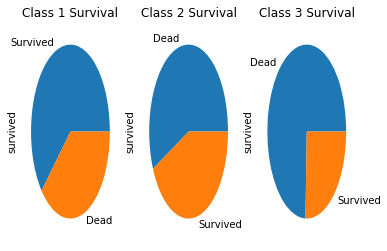

In [23]:
## -- 4 -- ##
titanic_data.survived.cat.categories = ['Dead', 'Survived']
pclass_grouped = titanic_data.groupby(titanic_data.pclass) # Group the passenger in each travel class
class_dict = dict(list(pclass_grouped))

# Calculate proportion
class1 = class_dict[1].survived.value_counts()[1]*100/(class_dict[1].survived.value_counts().sum())
class2 = class_dict[2].survived.value_counts()[1]*100/(class_dict[2].survived.value_counts().sum())
class3 = class_dict[3].survived.value_counts()[1]*100/(class_dict[3].survived.value_counts().sum())

print('The proportion of the passengers that survived for class 1 is : %f percent' % class1 )
print('The proportion of the passengers that survived for class 2 is : %f percent' % class2 )
print('The proportion of the passengers that survived for class 3 is : %f percent' % class3 )

# Pie charts
plt.subplot(131)
class_dict[1].survived.value_counts().plot(title = 'Class 1 Survival', kind='pie')
plt.subplot(132)
class_dict[2].survived.value_counts().plot(title = 'Class 2 Survival', kind='pie')
plt.subplot(133)
class_dict[3].survived.value_counts().plot(title = 'Class 3 Survival', kind='pie') 

Discussion 4 :
- One can notice that the proportion of passenger that survived in First class is more important that the 2 others. And the class with the lower proportion of survival is the Third class which makes sense since they were on the floors that were lower and therefore were far from the life boat and first affected by the sinking.

For Class1
The percentage of passenger female that survived is : 96.527778percent
The percentage of passenger male that survived is : 34.078212percent
For Class2
The percentage of passenger female that survived is : 88.679245percent
The percentage of passenger male that survived is : 14.619883percent
For Class3
The percentage of passenger female that survived is : 49.074074percent
The percentage of passenger male that survived is : 15.212982percent


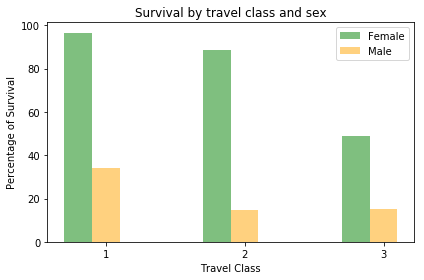

In [24]:
## -- 5 -- ##
f_sur = np.zeros(len(titanic_data.pclass.cat.categories))
m_sur = np.zeros(len(titanic_data.pclass.cat.categories))
sex_class_grouped = titanic_data.groupby(['pclass','sex']) # Group the passenger by travel class and sex
sex_class_dict = dict(list(sex_class_grouped))

for i,x in enumerate(titanic_data.pclass.cat.categories): # Loop that calculate the proportion of survival for each travel class and sex
    f_sur[i] = sex_class_dict[x,'female'].survived.value_counts()[1]*100/sex_class_dict[x,'female'].survived.value_counts().sum()
    m_sur[i] = sex_class_dict[x,'male'].survived.value_counts()[1]*100/sex_class_dict[x,'male'].survived.value_counts().sum()
    print('For Class' + str(x))
    print('The percentage of passenger female that survived is : %f' % f_sur[i] +'percent')
    print('The percentage of passenger male that survived is : %f' % m_sur[i] +'percent')
    
# Create a single histogram which represents the proportion of survival for each travel class and sex
travel = [1,2,3]
bar_width = 0.2
x = np.arange(len(titanic_data.pclass.cat.categories))
opacity = 0.5
plt.bar(x,f_sur,bar_width, color ='green', label = 'Female', alpha = opacity)
plt.bar(x + bar_width ,m_sur ,bar_width, color ='orange', label = 'Male', alpha = opacity)
plt.legend()
plt.xlabel('Travel Class')
plt.ylabel('Percentage of Survival')
plt.title('Survival by travel class and sex')
plt.xticks(x +bar_width, travel)
plt.tight_layout()
plt.show()

Discussion 5 :
- One can notice that the proportion of female that survived is higher that for male and this for each travel class. Besides the highest proportion of female that survived is in First class and lowest is in the Third Class
- One can notice that the proportion of male that survived in general is much lower that for female which makes sense because during a sinking the children and women are the first saved (Children and Ladies First !). And again the proportion of survival is higher in First class than the 2 other travel class.

For Class1
The percentage of passenger young female that survived is : 27.083333percent
The percentage of passenger old female that survived is : 69.444444percent
The percentage of passenger young male that survived is : 8.379888percent
The percentage of passenger old male that survived is : 25.698324percent
For Class2
The percentage of passenger young female that survived is : 45.283019percent
The percentage of passenger old female that survived is : 43.396226percent
The percentage of passenger young male that survived is : 9.356725percent
The percentage of passenger old male that survived is : 5.263158percent
For Class3
The percentage of passenger young female that survived is : 25.925926percent
The percentage of passenger old female that survived is : 23.148148percent
The percentage of passenger young male that survived is : 8.316430percent
The percentage of passenger old male that survived is : 6.896552percent


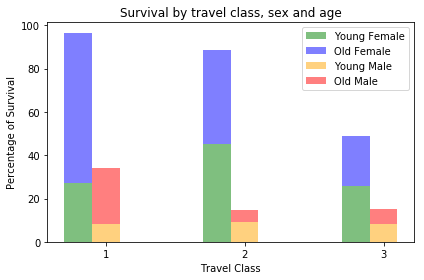

In [25]:
## -- 6 -- ##
Pop_1 = age_noNA.sort_values()[:523] # Create 2 equally populated age categories by sorting the age's values and taking the first 523 one since the number of age's value is 1046
Pop_2 = age_noNA.sort_values()[524:]

f_old_sur = np.zeros(len(titanic_data.pclass.cat.categories))
m_old_sur = np.zeros(len(titanic_data.pclass.cat.categories))
f_young_sur = np.zeros(len(titanic_data.pclass.cat.categories))
m_young_sur = np.zeros(len(titanic_data.pclass.cat.categories))

# Add new column in the dataframe with value 'Young' for the first group and 'Old' for the second group

population1 = pd.Series(['Young']*len(Pop_1.index), Pop_1.index) 
titanic_data['eq_pop'] = population1
titanic_data['eq_pop'] = titanic_data['eq_pop'].fillna(value ='Old')
titanic_data['eq_pop'] = titanic_data['eq_pop'].astype('category')
titanic_data.eq_pop.cat.categories = ['Old', 'Young']

sex_class_survived_grouped = titanic_data.groupby(['pclass','sex','survived']) # Group the passengers by travel class, sex and survival
sex_class_survived_dict = dict(list(sex_class_survived_grouped))

for i,x in enumerate(titanic_data.pclass.cat.categories):
    f_young_sur[i] = sex_class_survived_dict[x,'female','Survived'].eq_pop.value_counts()[1]*100/sex_class_dict[x,'female'].survived.value_counts().sum()
    f_old_sur[i] = sex_class_survived_dict[x,'female','Survived'].eq_pop.value_counts()[0]*100/sex_class_dict[x,'female'].survived.value_counts().sum()
    m_young_sur[i] = sex_class_survived_dict[x,'male','Survived'].eq_pop.value_counts()[1]*100/sex_class_dict[x,'male'].survived.value_counts().sum()
    m_old_sur[i] = sex_class_survived_dict[x,'male','Survived'].eq_pop.value_counts()[0]*100/sex_class_dict[x,'male'].survived.value_counts().sum()
    print('For Class' + str(x))
    print('The percentage of passenger young female that survived is : %f' % f_young_sur[i] +'percent')
    print('The percentage of passenger old female that survived is : %f' % f_old_sur[i] +'percent')
    print('The percentage of passenger young male that survived is : %f' % m_young_sur[i] +'percent')
    print('The percentage of passenger old male that survived is : %f' % m_old_sur[i]+'percent')

# Create one histogram that represents the proportion of survival depending on the travel class, sex, and the age's group
travel = [1,2,3]
bar_width = 0.2
x = np.arange(len(titanic_data.pclass.cat.categories))
opacity = 0.5
plt.bar(x,f_young_sur,bar_width, color ='green', label = 'Young Female', alpha = opacity)
plt.bar(x,f_old_sur,bar_width, color ='blue', label = 'Old Female', alpha = opacity, bottom = f_young_sur)
plt.bar(x + bar_width ,m_young_sur ,bar_width, color ='orange', label = 'Young Male', alpha = opacity)
plt.bar(x + bar_width ,m_old_sur ,bar_width, color ='red', label = 'Old Male', alpha = opacity, bottom = m_young_sur)
plt.legend()
plt.xlabel('Travel Class')
plt.ylabel('Percentage of Survival')
plt.title('Survival by travel class, sex and age')
plt.xticks(x +bar_width, travel)
plt.tight_layout()
plt.show()

Discussion 6 :
- One can notice that for both male and female the proportion of passenger who belong to the second that survived is higher than the other group for the First class unlike the 2 other travel class where the first group have a higher proportion of survival. 
- Besides, the difference between the 2 groups in much more important for the first class.

General conclusion :
- Regarding the proportion of passengers that survived. One can notice that there were a huge inegality of survival between the different travel class. Indeed, although the passenger of the second and third class were on lower decks so far from the life boats and the first affected by the water in the boat, we remembered that some of the rich passengers paid some amounts of money to get in the life boats.
- Besides, it makes sense that the proportion of women that survived is higher.

In conclusion, during the sinking of the Titanic, a class war really took place and the first class (rich people) won (at least for the women). However, we will remember the courtesy of the men who saved the children and women first (as we can see that the proportion of women that survived is much higher)